In [1]:
import pandas as pd
import numpy as np



In [2]:
# 读取数据
df = pd.read_excel('data/promoter_w_20799.xlsx',header=None,index_col=False)
df.head()

,0
0,TTGATAATTAATCATCCGGCTCGTATAAT
1,TTGACAATTAATCATCCGGCTCGTATAAT
2,TTGGTAATTAATCATCCGGCTCGTATAAT
3,TTGATAATTAATCATCCGGCTCGTAAAAT
4,TTGGCAATTAATCATCCGGCTCGTATAAT


In [3]:
dna_alphabet = 'ACGT'
char_to_int = {char: i for i, char in enumerate(dna_alphabet)}


In [4]:
# 提取分割数据到df_P

sequences= df[0]


In [5]:
# 对数据进行onehot编码。

# 初始化一个空的One-Hot编码矩阵
num_sequences = len(sequences)
sequence_length = len(sequences[0])
num_chars = len(dna_alphabet)
one_hot_matrix = np.zeros((num_sequences, sequence_length, num_chars))

# 遍历每个DNA序列并进行One-Hot编码
for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        if char in char_to_int:
            index = char_to_int[char]
            one_hot_matrix[i, j, index] = 1

# 将One-Hot编码矩阵转换为Pandas DataFrame
columns = [f"Position_{i+1}_{char}" for i in range(sequence_length) for char in dna_alphabet]
one_hot_df = pd.DataFrame(one_hot_matrix.reshape(num_sequences, -1), columns=columns)

# 打印One-Hot编码的DataFrame
print(one_hot_df)
# 这将生成一个包含One-Hot编码的Pandas DataFrame，其中每一行代表一个DNA序列，每一列代表一个位置和DNA字母的组合。每个位置上，只有一个字母对应的元素为1，表示该字母的类型。





       Position_1_A  Position_1_C  Position_1_G  Position_1_T  Position_2_A  \
0               0.0           0.0           0.0           1.0           0.0   
1               0.0           0.0           0.0           1.0           0.0   
2               0.0           0.0           0.0           1.0           0.0   
3               0.0           0.0           0.0           1.0           0.0   
4               0.0           0.0           0.0           1.0           0.0   
...             ...           ...           ...           ...           ...   
20794           0.0           1.0           0.0           0.0           1.0   
20795           0.0           0.0           0.0           1.0           1.0   
20796           0.0           0.0           0.0           1.0           0.0   
20797           0.0           1.0           0.0           0.0           0.0   
20798           0.0           1.0           0.0           0.0           0.0   

       Position_2_C  Position_2_G  Position_2_T  Po

In [6]:
y1 = pd.read_excel('data/fluorescence_w_20799.xlsx',header=None).to_numpy(dtype=float)
y1= np.log10(y1)
X = one_hot_matrix
X.shape

(20799, 29, 4)

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

if tf.config.experimental.list_physical_devices('GPU'):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=42)

# 创建训练集和测试集的tf.data.Dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y1_train)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y1_test)).batch(32)
# 设置交叉验证的折叠数
num_folds = 5  # 可以根据需要更改

# 初始化用于存储每个折叠的验证MSE的列表
mse_scores = []

# 创建K-fold交叉验证对象
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32,  3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))

    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # 输出层，使用线性激活函数
    return model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average

for train_index, val_index in kf.split(X_train,y1_train):
    # 根据交叉验证的拆分索引获取训练和验证数据
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y1_train_fold, y1_val_fold = y1_train[train_index], y1_train[val_index]

    # 创建一个新的模型实例
    input_layer = Input(shape=(29, 4))
    num_models = 5
    cnn_models = [create_cnn_model((29, 4))(input_layer) for _ in range(num_models)]
    merged = Average()(cnn_models)
    ensemble_model = Model(inputs=input_layer, outputs=merged)
    ensemble_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # 训练模型，并添加早停回调
    history = ensemble_model.fit(X_train_fold, y1_train_fold, epochs=1000, batch_size=128, 
                                validation_data=(X_val_fold, y1_val_fold), callbacks=[early_stopping])

    # 使用验证数据评估模型
    val_predictions = ensemble_model.predict(X_val_fold)
    mse = mean_squared_error(y1_val_fold, val_predictions)
    mse_scores.append(mse)

2023-10-08 16:46:57.972151: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-08 16:46:57.997448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 16:46:58.321360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-08 16:46:58.605630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

Epoch 1/1000


2023-10-08 16:47:01.195093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-10-08 16:47:01.569671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-08 16:47:01.572948: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x20379ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 16:47:01.572962: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-10-08 16:47:01.577464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 16:47:01.644927: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - 6s 12ms/step - loss: 0.0447 - mae: 0.1493 - val_loss: 0.0402 - val_mae: 0.1405
Epoch 2/1000
91/91 [==============================] - 1s 9ms/step - loss: 0.0429 - mae: 0.1451 - val_loss: 0.0400 - val_mae: 0.1405
Epoch 3/1000
91/91 [==============================] - 1s 9ms/step - loss: 0.0424 - mae: 0.1438 - val_loss: 0.0399 - val_mae: 0.1412
Epoch 4/1000
91/91 [==============================] - 1s 8ms/step - loss: 0.0422 - mae: 0.1435 - val_loss: 0.0397 - val_mae: 0.1402
Epoch 5/1000
91/91 [==============================] - 1s 9ms/step - loss: 0.0420 - mae: 0.1435 - val_loss: 0.0403 - val_mae: 0.1414
Epoch 6/1000
91/91 [==============================] - 1s 10ms/step - loss: 0.0420 - mae: 0.1437 - val_loss: 0.0393 - val_mae: 0.1402
Epoch 7/1000
91/91 [==============================] - 1s 9ms/step - loss: 0.0414 - mae: 0.1429 - val_loss: 0.0385 - val_mae: 0.1393
Epoch 8/1000
91/91 [==============================] - 1s 10ms/step - loss: 0.0408 - mae

7/7 [==============================] - 0s 1ms/step


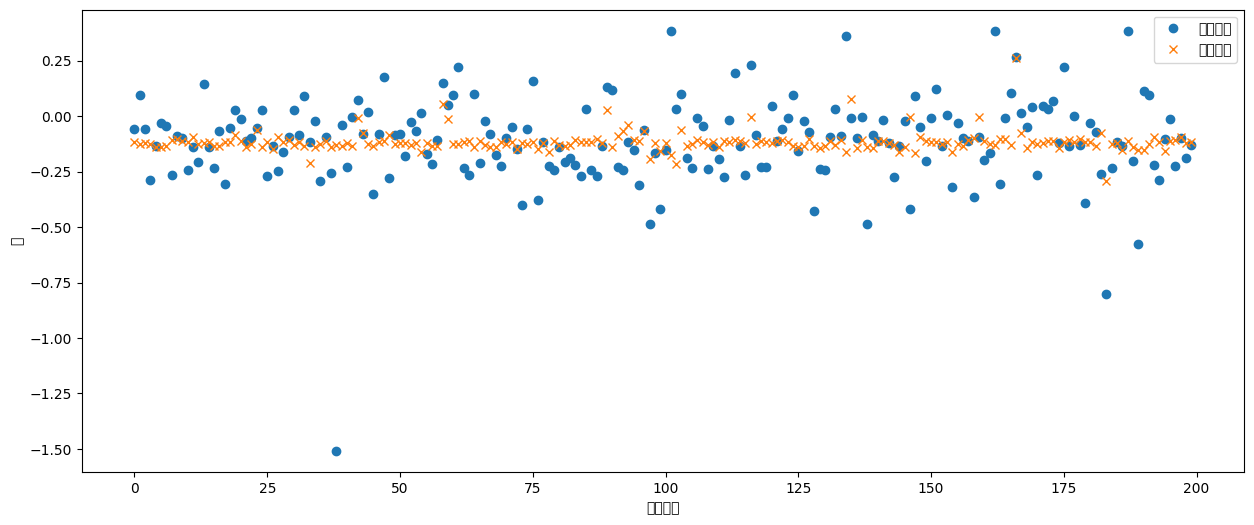

In [10]:
import matplotlib.pyplot as plt

# 使用模型进行预测
y_pred =ensemble_model.predict(X_test[:200])

# 将预测值和真实值提取出来
y_pred = y_pred.flatten()  # 将预测值展平成一维数组
y_true = y1_test[:200] # 真实值

# 创建一个新的图形
plt.figure(figsize=(15, 6))


# 绘制真实数据的点
plt.plot(y_true, label='真实数据', marker='o', linestyle='None')

# 绘制模型的预测数据的点
plt.plot(y_pred, label='模型预测', marker='x',linestyle='None')

# 添加标签和图例
plt.xlabel('样本索引')
plt.ylabel('值')
plt.legend()

# 显示图形
plt.show()

/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/IPython/c

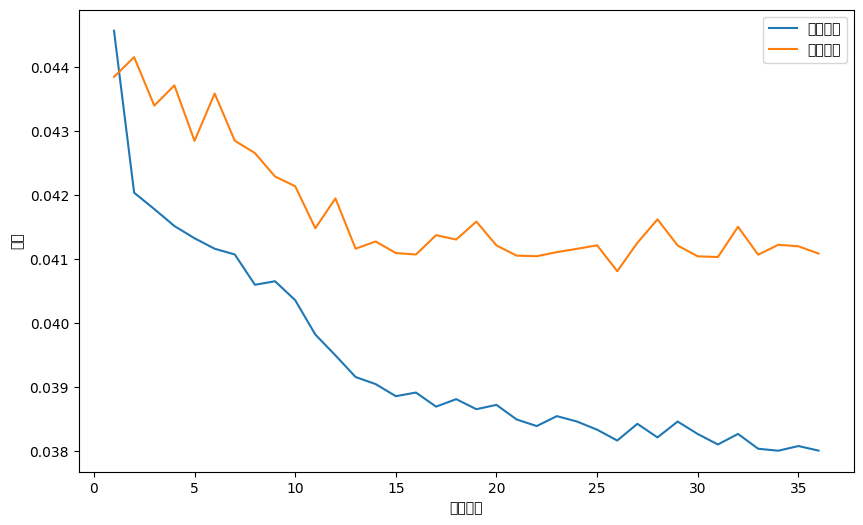

In [12]:
train_loss = history.history['loss']  # 训练损失
val_loss = history.history['val_loss']  # 验证损失
epochs = range(1, len(train_loss) + 1)  # 训练轮数

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制训练损失曲线
plt.plot(epochs, train_loss, label='训练损失', linestyle='-')

# 绘制验证损失曲线
plt.plot(epochs, val_loss, label='验证损失', linestyle='-')

# 添加标签和图例
plt.xlabel('训练轮数')
plt.ylabel('损失')
plt.legend()

# 显示图形
plt.show()


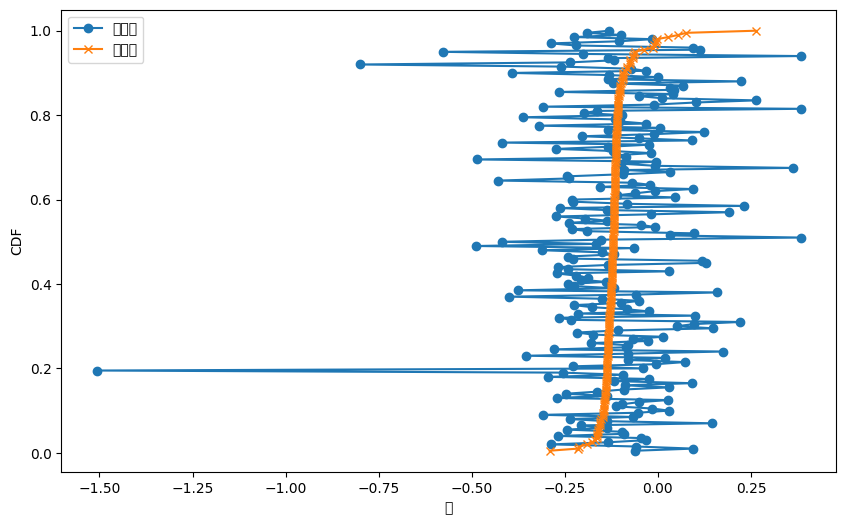

In [13]:
y_true_sorted =y_true
y_pred_sorted =y_pred
y_true_sorted = np.sort(y_true)
y_pred_sorted = np.sort(y_pred)
cdf_true = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
cdf_pred = np.arange(1, len(y_pred_sorted) + 1) / len(y_pred_sorted)

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制真实值的CDF
plt.plot(y_true_sorted, cdf_true, label='真实值', marker='o', linestyle='-')

# 绘制预测值的CDF
plt.plot(y_pred_sorted, cdf_pred, label='预测值', marker='x', linestyle='-')

# 添加标签和图例
plt.xlabel('值')
plt.ylabel('CDF')
plt.legend()

# 显示图形
plt.show()